In [1]:
import numpy as np
import cv2
import csv
import os
import json
from scipy.spatial import distance
from matplotlib import pyplot as plt

In [2]:
# define the needed paths to predict detections over images
test_images = "test_images"
test_results = "test_results"
csvReportsPath = "csvReports"

configFilesPath = "configfiles"
jsonPath = os.path.join(configFilesPath, "via_region_data.json")
labelsPath = os.path.join(configFilesPath, "classes.names")
weightsPath = os.path.abspath(os.path.join(configFilesPath, "darknet-yolov3_4800.weights"))
configPath = os.path.abspath(os.path.join(configFilesPath, "darknet-yolov3.cfg"))

In [3]:
def load_labels(labelsPath):
    """
        load the string class labels of the model
    """
    LABELS = open(labelsPath).read().strip().split("\n")
    
    return LABELS


def boundingBoxGroundTruth(jsonfilepath, filename):
    """
        get panel boxes for filename image
    """
    annotations = json.load(open(jsonfilepath))
    for a in annotations.values():
        if(a['filename'] == filename):
            imageValues = a
            polygons = [r['shape_attributes'] for r in imageValues['regions'].values()]
            boxes = []
            for p in polygons:
                x_list, y_list = p['all_points_x'], p['all_points_y']
                ymin, xmin, ymax, xmax = min(y_list), min(x_list), max(y_list), max(x_list)
                boxes.append((xmin, ymin, xmax, ymax))

    return boxes


def getCenterBox(box):
    """
        get center of bounding box define by (xmin,ymin,xmax,ymax)
    """
    x = box[2] - box[0]
    y = box[3] - box[1]

    return (x//2 + box[0], y//2 + box[1])


def pannelPercentageOccupacy(totalPixels, pannelPixels):
    """
     get ocuppation percentage of panel over all image(values between 0 and 1)   
    """
    return pannelPixels / totalPixels

In [4]:
def intersection_over_union(boxA, boxB):
    """
        calculate IoU accuracy measure: (xmin,ymin,xmax,ymax)
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])  # xmax
    yA = max(boxA[1], boxB[1])  # ymax
    xB = min(boxA[2], boxB[2])  # xmin
    yB = min(boxA[3], boxB[3])  # ymin

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [5]:
def groundTruthSizeGraph(jsonfilepath, csvfilepath):
    """
        create map with panels in groundtruth separates by panel size
    """
    
    count = [0,0,0,0,0,0,0]
    
    annotations = json.load(open(jsonfilepath))
    for a in annotations.values():
        img = cv2.imread(os.path.join('test_images',a['filename']))
        totalSize =  img.shape[0] * img.shape[1]
        
        polygons = [r['shape_attributes'] for r in a['regions'].values()]
        for p in polygons:
            x_list, y_list = p['all_points_x'], p['all_points_y']
            ymin, xmin, ymax, xmax = min(y_list), min(x_list), max(y_list), max(x_list)
            
            totalPanelSize = (ymax - ymin) * (xmax - xmin)
            percentage = pannelPercentageOccupacy(totalSize, totalPanelSize)
            
            # increment instance count
            if((percentage >= 0.0) and (percentage < 0.1)): count[0] += 1

            elif((percentage >= 0.1) and (percentage < 0.2)): count[1] += 1

            elif((percentage >= 0.2) and (percentage < 0.3)): count[2] += 1

            elif((percentage >= 0.3) and (percentage < 0.4)): count[3] += 1

            elif((percentage >= 0.4) and (percentage < 0.5)): count[4] += 1

            elif((percentage >= 0.5) and (percentage < 0.6)): count[5] += 1

            elif((percentage >= 0.6) and (percentage < 0.7)): count[6] += 1
            
      
                    
    x = np.arange(len(count))
    
    fig, axs = plt.subplots()
    plt.bar(x, count)
    axs.set_ylim(0,80)
    plt.xticks(x, tuple([str(i)+"-"+str(i+10)+"%" for i in range(0,70,10)]))
    
    fig.suptitle('GroundTruth Test:  number of real panels clasified by panel Size', fontsize=16)
    axs.set_ylabel('nº panels')
    axs.set_xlabel('panel size')
    plt.show()
    
    column_name = ['box size', 'nº boxes']

    csvfile = open(csvfilepath, 'w')
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(column_name)
    
    for idx, i in enumerate(range(0,70,10)):
        writer.writerow([str(i)+"-"+str(i+10)+"%", count[idx]])
        
    csvfile.close()

In [6]:
def get_net_prediction(net, image):
    """
        predict bounding boxes of image and associated probabilities
    """
    # determine only the output layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # construct a blob from image and perform a forward pass of the YOLO object detector
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    return layerOutputs

    
def predict_on_image(net, image):
    """
        predict detections over a single image
    """
    (H, W) = image.shape[:2]
    
    layerOutputs = get_net_prediction(net, image)
    
    # initialize lists of detected bounding boxes, confidences, and class IDs
    boxes, confidences, classIDs = [], [], []

    # loop over each of the layers and over each of detections
    for output in layerOutputs:
        for detection in output:
            # extract the class ID and confidence of the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # ensure the detected probability is greater than the minimum probability
            if confidence > 0.5:
                # scale the bounding box coordinates back relative to the size of the image
                # keeping in mind that YOLO actually returns the center(x, y) of the box
                # followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # get the top and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    
    return boxes, confidences, classIDs
    

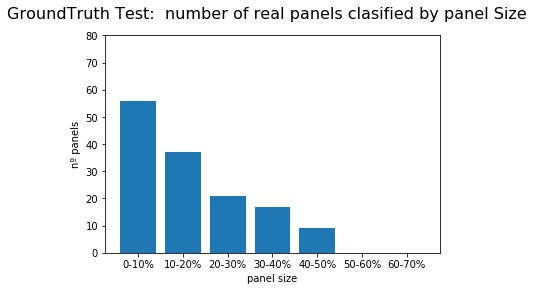

In [7]:
# show graphic
pathCsvSave = os.path.join(csvReportsPath, "size_panels.csv")

groundTruthSizeGraph(jsonPath, pathCsvSave)

In [8]:

# load our YOLO object detector trained on panels dataset (only 1 class)
net = cv2.dnn.readNetFromDarknet(os.path.abspath(configPath), os.path.abspath(weightsPath))

LABELS = load_labels(labelsPath)

predictedPrecisionMap = {}

for name in os.listdir(test_images):
    imagename = os.path.join(test_images, name)
    image = cv2.imread(imagename)
    (H, W) = image.shape[:2]

    # get groundtruth boxes for an image
    boxesTruth = boundingBoxGroundTruth(jsonPath, name)

    predictedPrecisionMap[name] = {
        'imagesize': W * H,
        'height_width': (H, W),
        'panelsOnImage': len(boxesTruth),
        'boxes': {}
    }

    boxes, confidences, classIDs = predict_on_image(net, image)
        
    # apply non-maxima suppression to suppress overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    # ensure at least one detection exists
    if len(idxs) > 0:
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (w, h) = (boxes[i][2], boxes[i][3])
            (xmin, ymin) = (boxes[i][0], boxes[i][1])
            (xmax, ymax) = (xmin + w, ymin + h)
            
            # draw a bounding box rectangle and label on the image
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0,255,0), 4)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            
            # coger el box de groundtruth más cercano
            c1 = getCenterBox((xmin,ymin,xmax,ymax))
            dist = [distance.euclidean(c1, getCenterBox(bt)) for bt in boxesTruth]
            index = dist.index(min(dist))
            box_labeled = boxesTruth[index]

            # calculo de IoU
            precision = intersection_over_union(box_labeled, (xmin,ymin,xmax,ymax))

            # dibujar el rectangulo etiquetado en color azul
            xmin_gt, ymin_gt, xmax_gt, ymax_gt = box_labeled
            cv2.rectangle(image, (xmin_gt, ymin_gt), (xmax_gt, ymax_gt), (255,0,0), 4)

            # calcular tamaño box etiquetada y box predicha
            panelSize = abs(xmin_gt - xmax_gt) * abs(ymin_gt - ymax_gt)
            predictPanelSize = abs(xmax - xmin) * abs(ymax - ymin)

            # save into dictionary
            idx = len(predictedPrecisionMap[name]['boxes'])

            predictedPrecisionMap[name]['boxes'][idx] = {
                'IoU':precision,
                'panelSize':pannelPercentageOccupacy(W * H, panelSize),
                'predictPanelSize' : pannelPercentageOccupacy(W * H, predictPanelSize),
                'prediction':[(xmax, ymax), (xmin, ymin)]
            }
            
    else:
        print("no hay detecciones en", name)
                      
    # show the output image
    image_dest = os.path.join(test_results, name)
    cv2.imwrite(image_dest, image)

with open('result.json', 'w') as fp:
    json.dump(predictedPrecisionMap, fp)

no hay detecciones en image129.jpg
no hay detecciones en image115.jpg
no hay detecciones en image116.jpg
no hay detecciones en image121.jpg
no hay detecciones en image103.jpg
no hay detecciones en image66.jpg
no hay detecciones en image91.jpg


In [9]:
# precision for detections (if a image has not box prediction, this no appear in statistics)

def predictionsHistogram(predictionMap, csvfilepath):
    # initial counts
    count = [0,0,0,0,0,0,0,0,0,0]
    
    # loop over image IoU
    for imageInfo in predictionMap.values():
        if len(imageInfo['boxes']) > 0:
            for pred in imageInfo['boxes'].values():
                iou = pred['IoU']
                
                # increment instance count
                if((iou >= 0.0) and (iou < 0.1)):
                    count[0] += 1
                elif((iou >= 0.1) and (iou < 0.2)):
                    count[1] += 1
                elif((iou >= 0.2) and (iou < 0.3)):
                    count[2] += 1
                elif((iou >= 0.3) and (iou < 0.4)):
                    count[3] += 1
                elif((iou >= 0.4) and (iou < 0.5)):
                    count[4] += 1
                elif((iou >= 0.5) and (iou < 0.6)):
                    count[5] += 1
                elif((iou >= 0.6) and (iou < 0.7)):
                    count[6] += 1
                elif((iou >= 0.7) and (iou < 0.8)):
                    count[7] += 1
                elif((iou >= 0.8) and (iou < 0.9)):
                    count[8] += 1
                else:
                    count[9] += 1
                
        
    x = np.arange(len(count))
    
    fig, axs = plt.subplots()
    plt.bar(x, count)
    plt.xticks(x, tuple([str(i*10) + "-" + str((i+1)*10) + "%" for i in range(len(count))]), rotation=90)
    
    fig.suptitle('Precision of Detections boxes', fontsize=16)
    axs.set_ylabel('nº images')
    axs.set_xlabel('precision box')
    plt.show()
    
    column_name = ['precision', 'nº boxes']
    
    csvfile = open(csvfilepath, 'w')
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(column_name)
    
    for i in range(len(count)):
        writer.writerow([str(i*10)+"-"+str((i+1)*10)+"%", count[i]])
        
    csvfile.close()

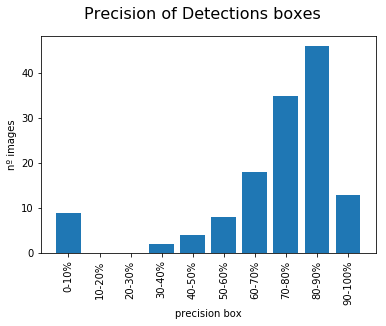

In [10]:
# show graphic
pathCsvSave = os.path.join(csvReportsPath, "percentage_panels.csv")

predictionsHistogram(predictedPrecisionMap, pathCsvSave) 

In [11]:
def percentagePanelSizeVsTotal(predictionMap, csvfilepath):
        count = [0,0,0,0,0,0,0]
        meanArray = [[],[],[],[],[],[],[]]
        
        # loop over image IoU
        for imageInfo in predictionMap.values():
            if(len(imageInfo['boxes']) > 0):
                for pred in imageInfo['boxes'].values():
                    size = pred['predictPanelSize']
                    
                    # increment instance count
                    if((size >= 0.0) and (size < 0.1)):
                        meanArray[0].append(pred['IoU'])
                        count[0] += 1
                    elif((size >= 0.1) and (size < 0.2)):
                        meanArray[1].append(pred['IoU'])
                        count[1] += 1
                    elif((size >= 0.2) and (size < 0.3)):
                        meanArray[2].append(pred['IoU'])
                        count[2] += 1
                    elif((size >= 0.3) and (size < 0.4)):
                        meanArray[3].append(pred['IoU'])
                        count[3] += 1
                    elif((size >= 0.4) and (size < 0.5)):
                        meanArray[4].append(pred['IoU'])
                        count[4] += 1
                    elif((size >= 0.5) and (size < 0.6)):
                        meanArray[5].append(pred['IoU'])
                        count[5] += 1
                    elif((size >= 0.6) and (size < 0.7)):
                        meanArray[6].append(pred['IoU'])
                        count[6] += 1
                    
              
        fig1 = plt.figure(1)
        x = np.arange(len(count))
        fig, axs = plt.subplots()
        plt.bar(x, count)
        plt.xticks(x, tuple([str(i)+"-"+str(i+10)+"%" for i in range(0,70,10)]))
        axs.set_ylabel('nº detections')
        axs.set_xlabel('panel size')
        fig1.show()
        
        
        fig2 = plt.figure(2)
        means = [sum(elem)/len(elem) if (len(elem) > 0) else 0 for elem in meanArray]
        fig, axs = plt.subplots()
        y = np.arange(len(meanArray))
        plt.bar(y, means)
        axs.set_ylabel('precision mean')
        axs.set_xlabel('panel size')
        plt.xticks(y, tuple([str(i)+"-"+str(i+10)+"%" for i in range(0,70,10)]))
        fig2.show()
        
        column_name = ['size','nº boxes', "precision mean"]
    
        csvfile = open(csvfilepath, 'w')
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(column_name)
    
        for i in range(len(count)):
            precision_mean = sum(meanArray[i])/len(meanArray[i]) if len(meanArray[i]) > 0 else 0
            writer.writerow([str(i*10)+"-"+str((i+1)*10)+"%", count[i], precision_mean])
        
        csvfile.close()

/home/angel/.virtualenvs/py3cv3/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 432x288 with 0 Axes>

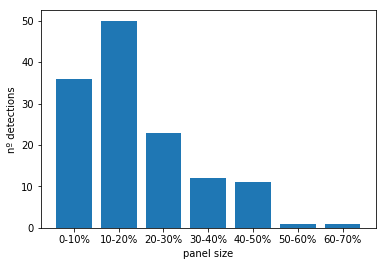

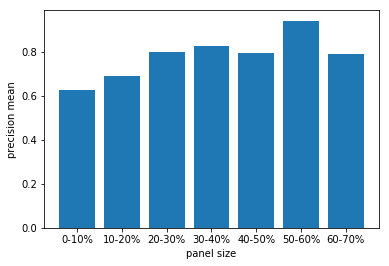

In [12]:
# show graphic
pathCsvSave = os.path.join(csvReportsPath, "size_panels_mean.csv")

percentagePanelSizeVsTotal(predictedPrecisionMap, pathCsvSave)

In [13]:
def createCsvSeparatedData(predictedMap, filename):

    with open(filename, mode='w') as report:
        
        csvwriter = csv.writer(report, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        csvwriter.writerow(['imagename', 'sizeImage', 'panelsOnImage', 'box_id', 'sizeBox', 'IoU'])

        for imagename in predictedMap.keys():
            panelsOnImage  = predictedMap[imagename]['panelsOnImage']

            sizeImage = predictedMap[imagename]['height_width']

            for idx in predictedMap[imagename]['boxes']:
                pmax, pmin = predictedMap[imagename]['boxes'][idx]['prediction']
                sizeBox = (pmax[1] - pmin[1], pmax[0] - pmin[0])

                IoU = predictedMap[imagename]['boxes'][idx]['IoU']

                csvwriter.writerow([imagename, sizeImage, panelsOnImage, idx, sizeBox, IoU])
                



In [14]:
# show graphic
pathCsvSave = os.path.join(csvReportsPath, "separated_report.csv")

createCsvSeparatedData(predictedPrecisionMap, pathCsvSave)